In [437]:
from data.cuhk_query import CUHK_Q

In [1]:
from __future__ import print_function, division
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from util.dataloader import DataLoader
from util.normalize import NormalizeImage
from util.torch_util import save_checkpoint
from model.network import AdaptReID
from data.duke import Duke
from data.market import Market
from data.msmt import MSMT
from data.cuhk import CUHK
from data.cuhk_query import CUHK_Q
from data.viper import VIPER
from data.caviar import CAVIAR
from parser.parser import ArgumentParser
from util.eval_utils import eval_metric
import config



/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected

In [49]:
class Argg():
    def __init__(self):
        self.gpu = 1
        self.source_dataset = 'CUHK'
        self.target_dataset = 'CUHK'
        self.extractor_path = '/home/yujheli/Project/ycchen/pretrained/CUHK/down_1_8/multi/Extractor_CUHK.pth.tar'
        self.extractor_path_H = '/home/yujheli/Project/ycchen/semi_group/H/Extractor_CUHK.pth.tar'
        self.extractor_path_HL = '/home/yujheli/Project/ycchen/semi_group/L/Extractor_CUHK.pth.tar'
        self.decoder_path = '/home/yujheli/Project/ycchen/pretrained/CUHK/down_1_8/multi/Decoder_CUHK.pth.tar'
        self.decoder_path_H = '/home/yujheli/Project/ycchen/semi_group/H/Decoder_CUHK.pth.tar'
        self.decoder_path_HL = '/home/yujheli/Project/ycchen/semi_group/L/Decoder_CUHK.pth.tar'
        
        
        
        self.batch_size = 32
        self.num_workers = 2
        self.dist_metric = 'L2'
        
        

In [50]:
args = Argg()

""" GPU Settings """
torch.cuda.set_device(args.gpu)
use_cuda = torch.cuda.is_available()


""" Initialize Model """
if args.source_dataset == 'Duke':
    classifier_output_dim = config.DUKE_CLASS_NUM
elif args.source_dataset == 'Market':
    classifier_output_dim = config.MARKET_CLASS_NUM
elif args.source_dataset == 'MSMT':
    classifier_output_dim = config.MSMT_CLASS_NUM
elif args.source_dataset == 'CUHK':
    classifier_output_dim = config.CUHK_CLASS_NUM
elif args.source_dataset == 'VIPER':
    classifier_output_dim = config.VIPER_CLASS_NUM
elif args.source_dataset == 'CAVIAR':
    classifier_output_dim = config.CAVIAR_CLASS_NUM

model_ours = AdaptReID(backbone='resnet-50',
                  use_cuda=use_cuda,
                  classifier_output_dim=classifier_output_dim)

model_H = AdaptReID(backbone='resnet-50',
                  use_cuda=use_cuda,
                  classifier_output_dim=classifier_output_dim)

model_HL = AdaptReID(backbone='resnet-50',
                  use_cuda=use_cuda,
                  classifier_output_dim=classifier_output_dim)

if args.extractor_path:
    print("Loading pre-trained extractor...")
    checkpoint = torch.load(args.extractor_path, map_location=lambda storage, loc: storage)
    for name, param in model_ours.extractor.state_dict().items():
        model_ours.extractor.state_dict()[name].copy_(checkpoint[name])
        
    checkpoint = torch.load(args.extractor_path_H, map_location=lambda storage, loc: storage)
    for name, param in model_H.extractor.state_dict().items():
        model_H.extractor.state_dict()[name].copy_(checkpoint[name])
        
    checkpoint = torch.load(args.extractor_path_HL, map_location=lambda storage, loc: storage)
    for name, param in model_HL.extractor.state_dict().items():
        model_HL.extractor.state_dict()[name].copy_(checkpoint[name])

if args.decoder_path:
    print("Loading pre-trained decoder...")
    checkpoint = torch.load(args.decoder_path, map_location=lambda storage, loc: storage)
    for name, param in model_ours.decoder.state_dict().items():
        model_ours.decoder.state_dict()[name].copy_(checkpoint[name])
        
        
        
        
if args.target_dataset == 'Duke':
    TestData = Duke
    QueryData = Duke
elif args.target_dataset == 'Market':
    TestData = Market
    QueryData = Market
elif args.target_dataset == 'MSMT':
    TestData = MSMT
    QueryData = MSMT
elif args.target_dataset == 'CUHK':
    TestData = CUHK
    QueryData = CUHK_Q
elif args.target_dataset == 'VIPER':
    TestData = VIPER
    QueryData = VIPER
elif args.target_dataset == 'CAVIAR':
    TestData = CAVIAR
    QueryData = CAVIAR


test_data = TestData(mode='test',
                     transform=NormalizeImage(['image']))

test_loader = DataLoader(test_data,
                         batch_size=args.batch_size,
                         num_workers=args.num_workers,
                         pin_memory=True)


query_data_1 = QueryData(mode='query',
                       transform=NormalizeImage(['image','rec_image']), query_name ='query_list.csv')

query_loader_1 = DataLoader(query_data_1,
                          batch_size=args.batch_size,
                          num_workers=args.num_workers,
                          pin_memory=True)

query_data_2 = QueryData(mode='query',
                       transform=NormalizeImage(['image','rec_image']), query_name = 'query_list_2.csv')

query_loader_2 = DataLoader(query_data_2,
                          batch_size=args.batch_size,
                          num_workers=args.num_workers,
                          pin_memory=True)

query_data_4 = QueryData(mode='query',
                       transform=NormalizeImage(['image','rec_image']), query_name = 'query_list_4.csv')

query_loader_4 = DataLoader(query_data_4,
                          batch_size=args.batch_size,
                          num_workers=args.num_workers,
                          pin_memory=True)

query_data_8 = QueryData(mode='query',
                       transform=NormalizeImage(['image','rec_image']), query_name = 'query_list_8.csv')

query_loader_8 = DataLoader(query_data_8,
                          batch_size=args.batch_size,
                          num_workers=args.num_workers,
                          pin_memory=True)

print('Start evaluation...')

# model.eval()
model_ours.eval()
model_H.eval()
model_HL.eval()
# mAP, cmc, rerank_mAP, rerank_cmc = eval_metric(args, model, test_loader, query_loader, re_rank=True)
# rank1, rank5, rank10, rank20 = cmc[[0,4,9,19]]

Loading pre-trained extractor...
Loading pre-trained decoder...
/home/yujheli/Project/ycchen/Adapt-ReID/data/csv/CUHK03/query_list.csv
/home/yujheli/Project/ycchen/Adapt-ReID/data/csv/CUHK03/query_list_2.csv
/home/yujheli/Project/ycchen/Adapt-ReID/data/csv/CUHK03/query_list_4.csv
/home/yujheli/Project/ycchen/Adapt-ReID/data/csv/CUHK03/query_list_8.csv
Start evaluation...


AdaptReID(
  (extractor): Extractor(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (downs

In [268]:
from scipy.spatial.distance import cdist

In [269]:

def extract_feature(dataloader, model):
    features_list = []
    infos = []
    for idx, batch in enumerate(dataloader):
        image = batch['image'].cuda()
        label = batch['label']
        camera_id = batch['camera_id']
        latent_feature, _, _, _, _, _ = model(image)
        b = latent_feature.size()[0]
        latent_feature = latent_feature.view(b, -1)
        latent_feature = latent_feature.data.cpu().numpy()
        label = label.data.numpy()
        camera_id = camera_id.data.numpy()
        for i in range(b):
            features_list.append(latent_feature[i])
            infos.append((label[i], camera_id[i]))
    return features_list, infos


def dist_metric(query_features, test_features):
#     if args.dist_metric == 'L2':
#         dist = 'euclidean'
#     elif args.dist_metric == 'L1':
#         dist = 'hamming'
#     elif args.dist_metric == 'cosine':
#         dist = 'cosine'
#     elif args.dist_metric == 'correlation':
#         dist = 'correlation'
    matrix = cdist(query_features, test_features, 'euclidean')
    return matrix



# test_features, test_infos = extract_feature(test_loader, model)


# query_features_1, query_infos_1 = extract_feature(query_loader_1, model)

# match = []
# junk = []

# for _, (query_person, query_camera) in enumerate(query_infos):
#     tmp_match = []
#     tmp_junk = []
#     for idx, (test_person, test_camera) in enumerate(test_infos):
#         if test_person == query_person and query_camera != test_camera:
#             tmp_match.append(idx)
#         elif test_person == query_person or test_person < 0:
#             tmp_junk.append(idx)
#     match.append(tmp_match)
#     junk.append(tmp_junk)

# dist_matrix = dist_metric(query_features, test_features)
# matrix_argsort_1 = np.argsort(dist_matrix, axis=1)

# #-------------------------------------------------------------------------------------------

# query_features, query_infos = extract_feature(query_loader_2, model)

# match = []
# junk = []

# for _, (query_person, query_camera) in enumerate(query_infos):
#     tmp_match = []
#     tmp_junk = []
#     for idx, (test_person, test_camera) in enumerate(test_infos):
#         if test_person == query_person and query_camera != test_camera:
#             tmp_match.append(idx)
#         elif test_person == query_person or test_person < 0:
#             tmp_junk.append(idx)
#     match.append(tmp_match)
#     junk.append(tmp_junk)

# dist_matrix = dist_metric(query_features, test_features)
# matrix_argsort_2 = np.argsort(dist_matrix, axis=1)

# #-------------------------------------------------------------------------------------------

# query_features, query_infos = extract_feature(query_loader_4, model)

# match = []
# junk = []

# for _, (query_person, query_camera) in enumerate(query_infos):
#     tmp_match = []
#     tmp_junk = []
#     for idx, (test_person, test_camera) in enumerate(test_infos):
#         if test_person == query_person and query_camera != test_camera:
#             tmp_match.append(idx)
#         elif test_person == query_person or test_person < 0:
#             tmp_junk.append(idx)
#     match.append(tmp_match)
#     junk.append(tmp_junk)

# dist_matrix = dist_metric(query_features, test_features)
# matrix_argsort_4 = np.argsort(dist_matrix, axis=1)

# #-------------------------------------------------------------------------------------------


# query_features, query_infos = extract_feature(query_loader_8, model)

# match = []
# junk = []

# for _, (query_person, query_camera) in enumerate(query_infos):
#     tmp_match = []
#     tmp_junk = []
#     for idx, (test_person, test_camera) in enumerate(test_infos):
#         if test_person == query_person and query_camera != test_camera:
#             tmp_match.append(idx)
#         elif test_person == query_person or test_person < 0:
#             tmp_junk.append(idx)
#     match.append(tmp_match)
#     junk.append(tmp_junk)

# dist_matrix = dist_metric(query_features, test_features)
# matrix_argsort_8 = np.argsort(dist_matrix, axis=1)


    


In [308]:
#Ours
test_features, test_infos = extract_feature(test_loader, model_ours)
query_features_1_ours, query_infos_1_ours = extract_feature(query_loader_1, model_ours)

match = []
junk = []

for _, (query_person, query_camera) in enumerate(query_infos_1_ours):
    tmp_match = []
    tmp_junk = []
    for idx, (test_person, test_camera) in enumerate(test_infos):
        if test_person == query_person and query_camera != test_camera:
            tmp_match.append(idx)
        elif test_person == query_person or test_person < 0:
            tmp_junk.append(idx)
    match.append(tmp_match)
    junk.append(tmp_junk)

dist_matrix = dist_metric(query_features_1_ours, test_features)
matrix_argsort_1_ours = np.argsort(dist_matrix, axis=1)

#-------------------------------------------------------------------------------------------

query_features_2_ours, query_infos_2_ours = extract_feature(query_loader_2, model_ours)

# match = []
# junk = []

# for _, (query_person, query_camera) in enumerate(query_infos_2_ours):
#     tmp_match = []
#     tmp_junk = []
#     for idx, (test_person, test_camera) in enumerate(query_infos_1_ours):
#         if test_person == query_person and query_camera != test_camera:
#             tmp_match.append(idx)
#         elif test_person == query_person or test_person < 0:
#             tmp_junk.append(idx)
#     match.append(tmp_match)
#     junk.append(tmp_junk)

dist_matrix = dist_metric(query_features_2_ours, test_features)
matrix_argsort_2_ours = np.argsort(dist_matrix, axis=1)

#-------------------------------------------------------------------------------------------
query_features_4_ours, query_infos_4_ours = extract_feature(query_loader_4, model_ours)

# match = []
# junk = []

# for _, (query_person, query_camera) in enumerate(query_infos_4_ours):
#     tmp_match = []
#     tmp_junk = []
#     for idx, (test_person, test_camera) in enumerate(query_infos_1_ours):
#         if test_person == query_person and query_camera != test_camera:
#             tmp_match.append(idx)
#         elif test_person == query_person or test_person < 0:
#             tmp_junk.append(idx)
#     match.append(tmp_match)
#     junk.append(tmp_junk)

dist_matrix = dist_metric(query_features_4_ours, test_features)
matrix_argsort_4_ours = np.argsort(dist_matrix, axis=1)

#-------------------------------------------------------------------------------------------
query_features_8_ours, query_infos_8_ours = extract_feature(query_loader_8, model_ours)

# match = []
# junk = []

# for _, (query_person, query_camera) in enumerate(query_infos_8_ours):
#     tmp_match = []
#     tmp_junk = []
#     for idx, (test_person, test_camera) in enumerate(query_infos_1_ours):
#         if test_person == query_person and query_camera != test_camera:
#             tmp_match.append(idx)
#         elif test_person == query_person or test_person < 0:
#             tmp_junk.append(idx)
#     match.append(tmp_match)
#     junk.append(tmp_junk)

dist_matrix = dist_metric(query_features_8_ours, test_features)
matrix_argsort_8_ours = np.argsort(dist_matrix, axis=1)

#-------------------------------------------------------------------------------------------

In [309]:
#H
query_features_1_H, query_infos_1_H = extract_feature(query_loader_1, model_H)
test_features, test_infos = extract_feature(test_loader, model_H)

match = []
junk = []

for _, (query_person, query_camera) in enumerate(query_infos_1_H):
    tmp_match = []
    tmp_junk = []
    for idx, (test_person, test_camera) in enumerate(test_infos):
        if test_person == query_person and query_camera != test_camera:
            tmp_match.append(idx)
        elif test_person == query_person or test_person < 0:
            tmp_junk.append(idx)
    match.append(tmp_match)
    junk.append(tmp_junk)

dist_matrix = dist_metric(query_features_1_H, test_features)
matrix_argsort_1_H = np.argsort(dist_matrix, axis=1)

#-------------------------------------------------------------------------------------------

query_features_2_H, query_infos_2_H = extract_feature(query_loader_2, model_H)

# match = []
# junk = []

# for _, (query_person, query_camera) in enumerate(query_infos_2_H):
#     tmp_match = []
#     tmp_junk = []
#     for idx, (test_person, test_camera) in enumerate(query_infos_1_H):
#         if test_person == query_person and query_camera != test_camera:
#             tmp_match.append(idx)
#         elif test_person == query_person or test_person < 0:
#             tmp_junk.append(idx)
#     match.append(tmp_match)
#     junk.append(tmp_junk)

dist_matrix = dist_metric(query_features_2_H, test_features)
matrix_argsort_2_H = np.argsort(dist_matrix, axis=1)

#-------------------------------------------------------------------------------------------
query_features_4_H, query_infos_4_H = extract_feature(query_loader_4, model_H)

# match = []
# junk = []

# for _, (query_person, query_camera) in enumerate(query_infos_4_H):
#     tmp_match = []
#     tmp_junk = []
#     for idx, (test_person, test_camera) in enumerate(query_infos_1_H):
#         if test_person == query_person and query_camera != test_camera:
#             tmp_match.append(idx)
#         elif test_person == query_person or test_person < 0:
#             tmp_junk.append(idx)
#     match.append(tmp_match)
#     junk.append(tmp_junk)

dist_matrix = dist_metric(query_features_4_H, test_features)
matrix_argsort_4_H = np.argsort(dist_matrix, axis=1)

#-------------------------------------------------------------------------------------------
query_features_8_H, query_infos_8_H = extract_feature(query_loader_8, model_H)

# match = []
# junk = []

# for _, (query_person, query_camera) in enumerate(query_infos_8_H):
#     tmp_match = []
#     tmp_junk = []
#     for idx, (test_person, test_camera) in enumerate(query_infos_1_H):
#         if test_person == query_person and query_camera != test_camera:
#             tmp_match.append(idx)
#         elif test_person == query_person or test_person < 0:
#             tmp_junk.append(idx)
#     match.append(tmp_match)
#     junk.append(tmp_junk)

dist_matrix = dist_metric(query_features_8_H, test_features)
matrix_argsort_8_H = np.argsort(dist_matrix, axis=1)

#-------------------------------------------------------------------------------------------

In [316]:
#HL
query_features_1_HL, query_infos_1_HL = extract_feature(query_loader_1, model_HL)
test_features, test_infos = extract_feature(test_loader, model_HL)

match = []
junk = []

for _, (query_person, query_camera) in enumerate(query_infos_1_HL):
    tmp_match = []
    tmp_junk = []
    for idx, (test_person, test_camera) in enumerate(test_infos):
        if test_person == query_person and query_camera != test_camera:
            tmp_match.append(idx)
        elif test_person == query_person or test_person < 0:
            tmp_junk.append(idx)
    match.append(tmp_match)
    junk.append(tmp_junk)

dist_matrix = dist_metric(query_features_1_HL, test_features)
matrix_argsort_1_HL = np.argsort(dist_matrix, axis=1)

#-------------------------------------------------------------------------------------------

query_features_2_HL, query_infos_2_HL = extract_feature(query_loader_2, model_HL)

# match = []
# junk = []

# for _, (query_person, query_camera) in enumerate(query_infos_2_HL):
#     tmp_match = []
#     tmp_junk = []
#     for idx, (test_person, test_camera) in enumerate(query_infos_2_HL):
#         if test_person == query_person and query_camera != test_camera:
#             tmp_match.append(idx)
#         elif test_person == query_person or test_person < 0:
#             tmp_junk.append(idx)
#     match.append(tmp_match)
#     junk.append(tmp_junk)

dist_matrix = dist_metric(query_features_2_HL, test_features)
matrix_argsort_2_HL = np.argsort(dist_matrix, axis=1)

#-------------------------------------------------------------------------------------------
query_features_4_HL, query_infos_4_HL = extract_feature(query_loader_4, model_HL)

# match = []
# junk = []

# for _, (query_person, query_camera) in enumerate(query_infos_4_HL):
#     tmp_match = []
#     tmp_junk = []
#     for idx, (test_person, test_camera) in enumerate(query_infos_4_HL):
#         if test_person == query_person and query_camera != test_camera:
#             tmp_match.append(idx)
#         elif test_person == query_person or test_person < 0:
#             tmp_junk.append(idx)
#     match.append(tmp_match)
#     junk.append(tmp_junk)

dist_matrix = dist_metric(query_features_4_HL, test_features)
matrix_argsort_4_HL = np.argsort(dist_matrix, axis=1)

#-------------------------------------------------------------------------------------------
query_features_8_HL, query_infos_8_HL = extract_feature(query_loader_8, model_HL)

# match = []
# junk = []

# for _, (query_person, query_camera) in enumerate(query_infos_8_HL):
#     tmp_match = []
#     tmp_junk = []
#     for idx, (test_person, test_camera) in enumerate(query_infos_8_HL):
#         if test_person == query_person and query_camera != test_camera:
#             tmp_match.append(idx)
#         elif test_person == query_person or test_person < 0:
#             tmp_junk.append(idx)
#     match.append(tmp_match)
#     junk.append(tmp_junk)

dist_matrix = dist_metric(query_features_8_HL, test_features)
matrix_argsort_8_HL = np.argsort(dist_matrix, axis=1)

#-------------------------------------------------------------------------------------------

In [323]:
CMC = np.zeros([len(query_features_1_ours), len(test_features)])    

for idx in range(len(query_features)):
    counter = 0
    for i in range(len(test_features)):
        if matrix_argsort_8[idx][i] in junk[idx]:
            continue
        else:
            counter += 1
            if matrix_argsort_8[idx][i] in match[idx]:
                CMC[idx, counter-1:] = 1
            if counter == 20:
                break
rank_1 = np.mean(CMC[:,0])

In [6]:
from skimage import io

In [10]:
loader_ = enumerate(query_loader_1)
_, batch_ = next(loader_)

In [11]:
image_1 = batch_['image'].data.cpu().numpy()

In [149]:
image_2 = batch_['image'].data.cpu().numpy()

In [7]:
image_4 = batch_['image'].data.cpu().numpy()


In [77]:
io.imsave('sample.png',np.transpose(image_1[2].clip(-1,1),(1,2,0)))


/home/yujheli/.local/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [78]:
ls

config.py    parser/           sample.pdf       train-multi.sh
data/        pre-train-cls.py  sample.png       train.py
eval.py      pre-train-cls.sh  sample.py        train.sh
eval.sh      pre-train-rec.py  semi.pdf         transform/
evaluate.py  pre-train-rec.sh  setup.py         util/
loss/        __pycache__/      trained_models/  Visualization.ipynb
model/       README.md         train-multi.py


In [52]:
matrix_argsort_1

array([[   0,    5,    7, ...,  351, 1701,  346],
       [   1,    8,    6, ...,  578,  351,  346],
       [   2,    7,    3, ...,  343,  351,  346],
       ...,
       [1927, 1922, 1924, ...,  579,  573,  578],
       [1928, 1923, 1929, ...,  351, 1701,  346],
       [1929, 1924, 1922, ...,  573,  346,  578]])

In [ ]:
rm *

In [432]:
test_data = TestData(mode='test',
                     transform=NormalizeImage(['image']))

test_loader = DataLoader(test_data,
                         batch_size=1,
                         num_workers=args.num_workers,
                         pin_memory=True)
# loader_ = enumerate(test_loader)
# _, batch_ = next(loader_)
for idx, batch in enumerate(test_loader):
    if idx in set(Sample_list):
        image = batch['image'].data.cpu().numpy()
        io.imsave('Rank-sample-image-for-cuhk/{}.png'.format(idx),np.transpose(image[0]/2+0.5,(1,2,0)).clip(0,1))

        

/home/yujheli/.local/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/home/yujheli/.local/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/yujheli/.local/lib/python3.5/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


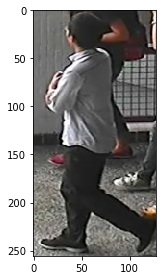

In [121]:
io.imshow(np.transpose(((batch_['image'].data.cpu().numpy()[0]/2)+0.5).clip(0,1), (1,2,0)))

/home/yujheli/.local/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/yujheli/.local/lib/python3.5/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


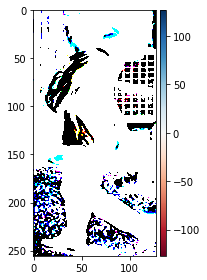

In [119]:
io.imshow(np.transpose(((batch_['image'].data.cpu().numpy()[0]/2)+0.5)*255, (1,2,0)).clip(0,255).astype('int8'))

In [118]:
((batch_['image'].data.cpu().numpy()[0]/2)+0.5)*255 

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [424]:
Sample_list = []

In [431]:
set(Sample_list)

{146,
 151,
 197,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 412,
 415,
 416,
 519,
 598,
 600,
 601,
 602,
 605,
 606,
 607,
 952,
 1187,
 1190,
 1194,
 1197,
 1227,
 1526,
 1739,
 1902}

In [426]:
index_n = 240
list_1 = list(matrix_argsort_1_ours[index_n])
list_2 = list(matrix_argsort_2_ours[index_n])
list_4 = list(matrix_argsort_4_ours[index_n])
list_8 = list(matrix_argsort_8_ours[index_n])

for i in junk[index_n]:
    list_1.remove(i)
    list_2.remove(i)
    list_4.remove(i)
    list_8.remove(i)

print(list_1[:10])
print(list_2[:10])
print(list_4[:10])
print(list_8[:10])
print(match[index_n])
Sample_list += list_1[:10]
Sample_list += list_2[:10]
Sample_list += list_4[:10]
Sample_list += list_8[:10]

[251, 246, 244, 250, 245, 249, 248, 243, 242, 247]
[246, 251, 245, 250, 244, 247, 242, 243, 248, 249]
[248, 243, 245, 250, 251, 246, 249, 244, 242, 247]
[243, 248, 245, 250, 249, 244, 246, 251, 242, 247]
[242, 243, 244, 245, 246, 247, 248, 249, 250, 251]


In [428]:
index_n = 240
list_1 = list(matrix_argsort_1_H[index_n])
list_2 = list(matrix_argsort_2_H[index_n])
list_4 = list(matrix_argsort_4_H[index_n])
list_8 = list(matrix_argsort_8_H[index_n])

for i in junk[index_n]:
    list_1.remove(i)
    list_2.remove(i)
    list_4.remove(i)
    list_8.remove(i)

print(list_1[:10])
print(list_2[:10])
print(list_4[:10])
print(list_8[:10])
print(match[index_n])
Sample_list += list_1[:10]
Sample_list += list_2[:10]
Sample_list += list_4[:10]
Sample_list += list_8[:10]

[249, 242, 247, 412, 952, 244, 416, 415, 1902, 246]
[247, 242, 244, 250, 245, 249, 248, 243, 246, 251]
[146, 151, 197, 245, 250, 244, 519, 1739, 1526, 247]
[146, 151, 197, 1197, 1187, 1194, 519, 1227, 1190, 1739]
[242, 243, 244, 245, 246, 247, 248, 249, 250, 251]


In [429]:
index_n = 240
list_1 = list(matrix_argsort_1_HL[index_n])
list_2 = list(matrix_argsort_2_HL[index_n])
list_4 = list(matrix_argsort_4_HL[index_n])
list_8 = list(matrix_argsort_8_HL[index_n])

for i in junk[index_n]:
    list_1.remove(i)
    list_2.remove(i)
    list_4.remove(i)
    list_8.remove(i)

print(list_1[:10])
print(list_2[:10])
print(list_4[:10])
print(list_8[:10])
print(match[index_n])
Sample_list += list_1[:10]
Sample_list += list_2[:10]
Sample_list += list_4[:10]
Sample_list += list_8[:10]

[247, 242, 244, 249, 248, 243, 246, 251, 250, 245]
[242, 247, 249, 244, 243, 248, 246, 251, 245, 250]
[243, 248, 247, 242, 602, 412, 601, 416, 598, 244]
[602, 605, 607, 601, 248, 243, 598, 606, 600, 412]
[242, 243, 244, 245, 246, 247, 248, 249, 250, 251]


In [37]:
SAVE_list = [704, 709, 703, 402, 549, 564, 700, 697, 554, 701, 557, 408, 403, 411, 406, 402, 565, 562, 407, 708]

In [57]:
index_list = []
for index, data in enumerate(CMC):
    if data[0] == 1:
        index_list.append(index)

TypeError: list indices must be integers or slices, not tuple

In [350]:
index_list

[58,
 63,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 78,
 79,
 80,
 81,
 82,
 83,
 86,
 89,
 90,
 91,
 94,
 95,
 114,
 137,
 140,
 142,
 143,
 144,
 145,
 147,
 148,
 149,
 150,
 202,
 207,
 232,
 234,
 236,
 237,
 239,
 241,
 296,
 302,
 303,
 304,
 306,
 307,
 308,
 309,
 310,
 311,
 395,
 400,
 401,
 405,
 406,
 410,
 458,
 463,
 464,
 468,
 469,
 470,
 473,
 474,
 475,
 481,
 484,
 486,
 487,
 546,
 549,
 553,
 554,
 555,
 558,
 560,
 563,
 564,
 598,
 600,
 601,
 602,
 605,
 606,
 608,
 609,
 611,
 612,
 613,
 614,
 616,
 617,
 619,
 624,
 628,
 629,
 630,
 632,
 634,
 635,
 637,
 653,
 654,
 655,
 656,
 658,
 659,
 660,
 661,
 662,
 664,
 667,
 669,
 692,
 693,
 694,
 695,
 696,
 697,
 698,
 699,
 700,
 701,
 702,
 705,
 707,
 710,
 735,
 739,
 740,
 746,
 762,
 763,
 764,
 765,
 766,
 767,
 768,
 770,
 771,
 792,
 793,
 794,
 795,
 796,
 797,
 798,
 799,
 800,
 801,
 802,
 803,
 805,
 807,
 808,
 809,
 906,
 907,
 908,
 909,
 910,
 916,
 919,
 921,
 924,
 986,
 988,

In [358]:
good_id = {}
cnt = 0
for i in index_list:
    if test_infos[i][0] not in good_id:
        good_id[test_infos[i][0]] = cnt
        cnt+=1

In [334]:
good_id = dict(zip(range(50),range(50)))

In [370]:
cnt = 35
for i in range(25):
    if i not in good_id:
        good_id[i] = cnt
        cnt+=1

In [371]:
len(good_id)

50

In [378]:
good_id

{0: 35,
 1: 36,
 2: 37,
 3: 0,
 4: 1,
 5: 2,
 6: 38,
 7: 3,
 8: 39,
 9: 40,
 10: 4,
 11: 41,
 12: 5,
 13: 42,
 14: 43,
 15: 6,
 16: 44,
 17: 45,
 18: 46,
 19: 47,
 20: 7,
 21: 48,
 22: 49,
 23: 8,
 24: 9,
 28: 10,
 31: 11,
 32: 12,
 34: 13,
 36: 14,
 38: 15,
 39: 16,
 41: 17,
 47: 18,
 51: 19,
 52: 20,
 55: 21,
 61: 22,
 62: 23,
 63: 24,
 65: 25,
 66: 26,
 82: 27,
 85: 28,
 86: 29,
 89: 30,
 91: 31,
 92: 32,
 93: 33,
 96: 34}

In [328]:
[i for i in list(good_id.keys())]

[65,
 66,
 3,
 4,
 5,
 7,
 96,
 10,
 12,
 15,
 92,
 82,
 20,
 85,
 86,
 23,
 24,
 89,
 91,
 28,
 93,
 31,
 32,
 34,
 36,
 38,
 39,
 41,
 47,
 51,
 52,
 55,
 61,
 62,
 63]

In [436]:
query_loader_4 = DataLoader(query_data_4,
                          batch_size=1,
                          num_workers=args.num_workers,
                          pin_memory=True)

for idx, batch in enumerate(query_loader_4):
#     print (idx)
    if idx == 240:
        image = batch['image'].data.cpu().numpy()
#         io.imsave('Rank-sample-image-for-cuhk/Q_8.png',np.transpose(image[0].clip(-1,1),(1,2,0)))
        io.imsave('Rank-sample-image-for-cuhk/Q_4.png'.format(idx),np.transpose(image[0]/2+0.5,(1,2,0)).clip(0,1))

/home/yujheli/.local/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [43]:
query_data_1 = QueryData(mode='query',
                       transform=NormalizeImage(['image', 'rec_image']), query_name ='query_list.csv')

query_loader_1 = DataLoader(query_data_1,
                          batch_size=32,
                          num_workers=args.num_workers,
                          pin_memory=True)

query_data_2 = QueryData(mode='query',
                       transform=NormalizeImage(['image', 'rec_image']), query_name = 'query_list_2.csv')

query_loader_2 = DataLoader(query_data_2,
                          batch_size=32,
                          num_workers=args.num_workers,
                          pin_memory=True)

query_data_4 = QueryData(mode='query',
                       transform=NormalizeImage(['image', 'rec_image']), query_name = 'query_list_4.csv')

query_loader_4 = DataLoader(query_data_4,
                          batch_size=32,
                          num_workers=args.num_workers,
                          pin_memory=True)

query_data_8 = QueryData(mode='query',
                       transform=NormalizeImage(['image', 'rec_image']), query_name = 'query_list_8.csv')

query_loader_8 = DataLoader(query_data_8,
                          batch_size=32,
                          num_workers=args.num_workers,
                          pin_memory=True)

/home/yujheli/Project/ycchen/Adapt-ReID/data/csv/CUHK03/query_list.csv
/home/yujheli/Project/ycchen/Adapt-ReID/data/csv/CUHK03/query_list_2.csv
/home/yujheli/Project/ycchen/Adapt-ReID/data/csv/CUHK03/query_list_4.csv
/home/yujheli/Project/ycchen/Adapt-ReID/data/csv/CUHK03/query_list_8.csv


In [51]:

# cnt = 0
# for idx, batch in enumerate(query_loader_2):
#     image = batch['image'].cuda()
# #     label = batch['label']
#     camera_id = batch['camera_id']
    
#     latent_source, features_source, cls_source, rec_image, global_feature_source, local_feature_source = model_ours(image)
#     image = batch['image'].data.cpu().numpy()
#     rec_image = rec_image.data.cpu().numpy()
#     rec_image_gt = batch['rec_image'].data.cpu().numpy()
#     io.imsave('Rank-sample-image-for-cuhk/2_down_{}.png'.format(cnt),np.transpose(image[0]/2+0.5,(1,2,0)).clip(0,1))
#     io.imsave('Rank-sample-image-for-cuhk/2_rec_{}.png'.format(cnt),np.transpose(rec_image[0]/2+0.5,(1,2,0)).clip(0,1))
#     io.imsave('Rank-sample-image-for-cuhk/2_ori_{}.png'.format(cnt),np.transpose(rec_image_gt[0]/2+0.5,(1,2,0)).clip(0,1))
    
    
# #     io.imshow(np.transpose(rec_image[0]/2+0.5,(1,2,0)).clip(0,1))
# #     io.imshow(np.transpose(rec_image_gt[0]/2+0.5,(1,2,0)).clip(0,1))
# #     print(image)
# #     print(rec_image_gt)
# #     print(rec_image)
#     cnt += 1
#     if cnt == 6:
#         break
    
    
    
# cnt = 0  
# for idx, batch in enumerate(query_loader_4):
#     image = batch['image'].cuda()
# #     label = batch['label']
#     camera_id = batch['camera_id']
    
#     latent_source, features_source, cls_source, rec_image, global_feature_source, local_feature_source = model_ours(image)
#     image = batch['image'].data.cpu().numpy()
#     rec_image = rec_image.data.cpu().numpy()
#     rec_image_gt = batch['rec_image'].data.cpu().numpy()
#     io.imsave('Rank-sample-image-for-cuhk/4_down_{}.png'.format(cnt),np.transpose(image[0]/2+0.5,(1,2,0)).clip(0,1))
#     io.imsave('Rank-sample-image-for-cuhk/4_rec_{}.png'.format(cnt),np.transpose(rec_image[0]/2+0.5,(1,2,0)).clip(0,1))
#     io.imsave('Rank-sample-image-for-cuhk/4_ori_{}.png'.format(cnt),np.transpose(rec_image_gt[0]/2+0.5,(1,2,0)).clip(0,1))
    
    
# #     io.imshow(np.transpose(rec_image[0]/2+0.5,(1,2,0)).clip(0,1))
# #     io.imshow(np.transpose(rec_image_gt[0]/2+0.5,(1,2,0)).clip(0,1))
# #     print(image)
# #     print(rec_image_gt)
# #     print(rec_image)
#     cnt += 1
#     if cnt == 6:
#         break
    
    
cnt = 0    
for idx, batch in enumerate(query_loader_8):
    image = batch['image'].cuda()
#     label = batch['label']
    camera_id = batch['camera_id']
    
    latent_source, features_source, cls_source, rec_image, global_feature_source, local_feature_source = model_ours(image)
    image = batch['image'].data.cpu().numpy()
    rec_image = rec_image.data.cpu().numpy()
    rec_image_gt = batch['rec_image'].data.cpu().numpy()
    io.imsave('Rank-sample-image-for-cuhk/8_down_{}.png'.format(cnt),np.transpose(image[0]/2+0.5,(1,2,0)).clip(0,1))
    io.imsave('Rank-sample-image-for-cuhk/8_rec_{}.png'.format(cnt),np.transpose(rec_image[0]/2+0.5,(1,2,0)).clip(0,1))
    io.imsave('Rank-sample-image-for-cuhk/8_ori_{}.png'.format(cnt),np.transpose(rec_image_gt[0]/2+0.5,(1,2,0)).clip(0,1))
    
    
#     io.imshow(np.transpose(rec_image[0]/2+0.5,(1,2,0)).clip(0,1))
#     io.imshow(np.transpose(rec_image_gt[0]/2+0.5,(1,2,0)).clip(0,1))
#     print(image)
#     print(rec_image_gt)
#     print(rec_image)
    cnt += 1
    if cnt == 6:
        break
    


/home/yujheli/.local/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [395]:
features_list = []
infos = []
downsamples = []
for idx, batch in enumerate(query_loader_1):
    image = batch['image'].cuda()
    label = batch['label']
    camera_id = batch['camera_id']
    rec_image = batch['rec_image']
    latent_feature, _, _, _, _, _ = model_HL(image)
    b = latent_feature.size()[0]
    latent_feature = latent_feature.view(b, -1)
    latent_feature = latent_feature.data.cpu().numpy()
    label = label.data.numpy()
    camera_id = camera_id.data.numpy()
    for i in range(b):
        if label[i] in list(good_id.keys()):
            features_list.append(latent_feature[i])
            infos.append(good_id[label[i]])
            downsamples.append(1)
        
for idx, batch in enumerate(query_loader_2):
    image = batch['image'].cuda()
    label = batch['label']
    camera_id = batch['camera_id']
    rec_image = batch['rec_image']
    latent_feature, _, _, _, _, _ = model_HL(image)
    b = latent_feature.size()[0]
    latent_feature = latent_feature.view(b, -1)
    latent_feature = latent_feature.data.cpu().numpy()
    label = label.data.numpy()
    camera_id = camera_id.data.numpy()
    for i in range(b):
        if label[i] in list(good_id.keys()):
            features_list.append(latent_feature[i])
            infos.append(good_id[label[i]])
            downsamples.append(2)
        
for idx, batch in enumerate(query_loader_4):
    image = batch['image'].cuda()
    label = batch['label']
    camera_id = batch['camera_id']
    rec_image = batch['rec_image']
    latent_feature, _, _, _, _, _ = model_HL(image)
    b = latent_feature.size()[0]
    latent_feature = latent_feature.view(b, -1)
    latent_feature = latent_feature.data.cpu().numpy()
    label = label.data.numpy()
    camera_id = camera_id.data.numpy()
    for i in range(b):
        if label[i] in list(good_id.keys()):
            features_list.append(latent_feature[i])
            infos.append(good_id[label[i]])
            downsamples.append(3)
    
for idx, batch in enumerate(query_loader_8):
    image = batch['image'].cuda()
    label = batch['label']
    camera_id = batch['camera_id']
    rec_image = batch['rec_image']
    latent_feature, _, _, _, _, _ = model_HL(image)
    b = latent_feature.size()[0]
    latent_feature = latent_feature.view(b, -1)
    latent_feature = latent_feature.data.cpu().numpy()
    label = label.data.numpy()
    camera_id = camera_id.data.numpy()
    for i in range(b):
        if label[i] in list(good_id.keys()):
            features_list.append(latent_feature[i])
            infos.append(good_id[label[i]])
            downsamples.append(4)
        

In [396]:
from sklearn.manifold import TSNE
# load up data

x_data = np.stack(features_list)
y_data = np.stack(infos)

X_embedded = TSNE(n_components=2).fit_transform(x_data)

<Figure size 2880x2880 with 0 Axes>

/home/yujheli/.local/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


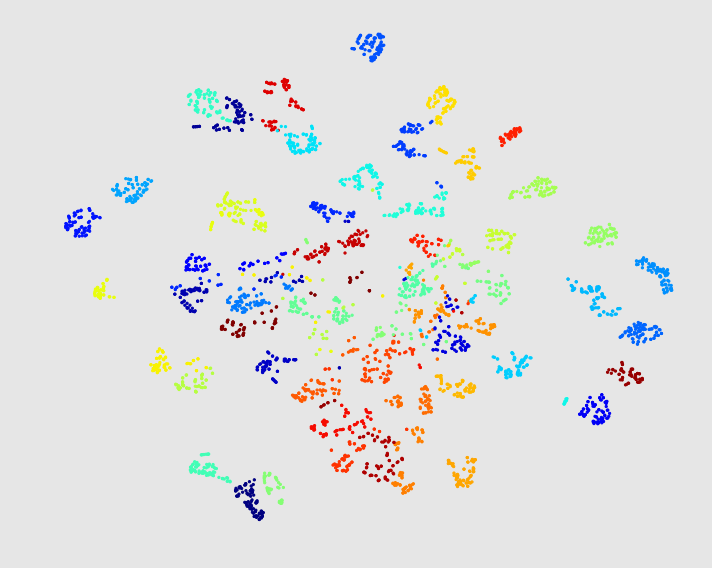

In [403]:
from pylab import rcParams

rcParams.update({'figure.autolayout': True})
rcParams['figure.figsize'] = 40, 40
bg_color = '#E6E6E6'
plt.figure(1)
fig, ax = plt.subplots(figsize=(10,8), facecolor=bg_color)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=np.stack(infos), cmap=plt.cm.get_cmap("jet", 50),s=5)
# cbar = plt.colorbar()
# cbar.ax.get_yaxis().set_ticks([])
# for j, lab in enumerate(range(1,51,1)):
#     cbar.ax.text(-0.5, (2 * j + 1) / 100.0, lab, ha='center', va='center')
# cbar.ax.get_yaxis().labelpad = 20
# cbar.ax.set_ylabel('Image Label', rotation=270, fontsize=15)


plt.axis('off')

# plt.clim(-0.5, 9.5)
plt.savefig('Identity_tsne_50_HL_n_bar.pdf')

<Figure size 2160x2880 with 0 Axes>

/home/yujheli/.local/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


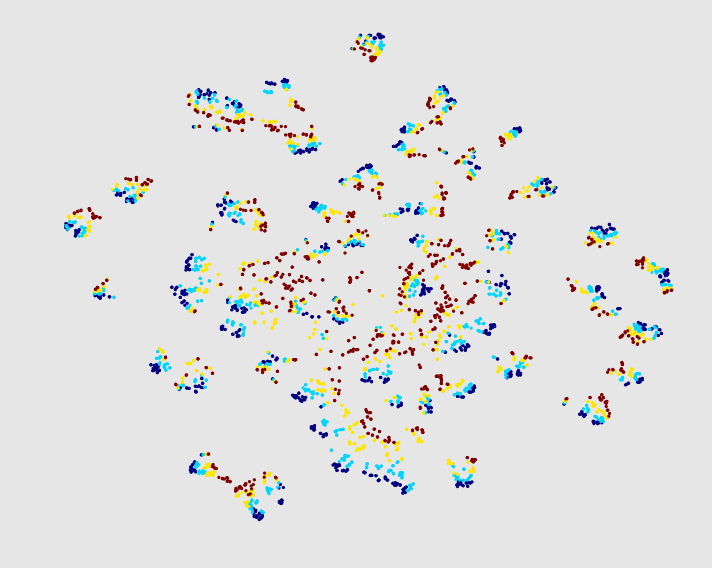

In [399]:
from pylab import rcParams

rcParams.update({'figure.autolayout': True})
rcParams['figure.figsize'] = 30, 40

bg_color = '#E6E6E6'
plt.figure(1)
fig, ax = plt.subplots(figsize=(10,8), facecolor=bg_color)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=np.stack(downsamples), cmap=plt.cm.get_cmap("jet", 4),s=5)
# cbar = plt.colorbar()
# cbar.ax.get_yaxis().set_ticks([])
# for j, lab in enumerate(['$1$','$2$','$4$','$8$']):
#     cbar.ax.text(-.5, (2 * j + 1) / 8.0, lab, ha='center', va='center', fontsize=15)
# cbar.ax.get_yaxis().labelpad = 20
# cbar.ax.set_ylabel('Down-sampling Rate', rotation=270, fontsize=15)

# plt.clim(-0.5, 9.5)
plt.axis('off')
plt.savefig('Reso_tsne_50_HL_n_bar.pdf')

<Figure size 2880x2880 with 0 Axes>

/home/yujheli/.local/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


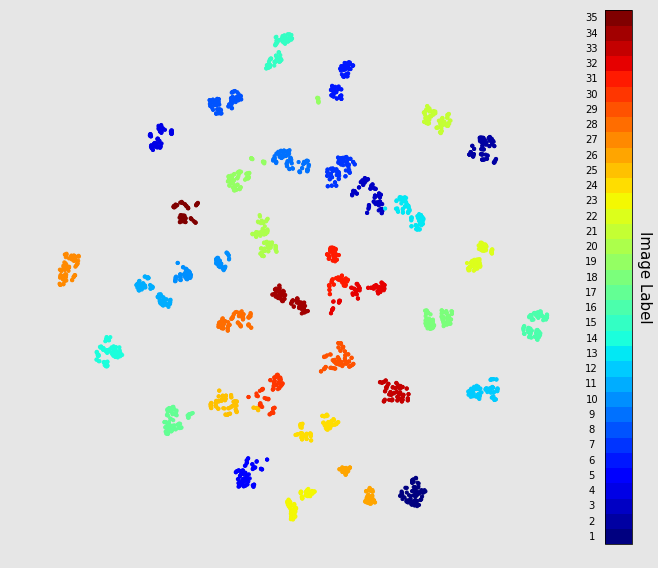

In [260]:
from pylab import rcParams

rcParams.update({'figure.autolayout': True})
rcParams['figure.figsize'] = 40, 40
bg_color = '#E6E6E6'
plt.figure(1)
fig, ax = plt.subplots(figsize=(10,8), facecolor=bg_color)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=np.stack(infos), cmap=plt.cm.get_cmap("jet", 35),s=10)
cbar = plt.colorbar()
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(range(1,36,1)):
    cbar.ax.text(-0.5, (2 * j + 1) / 70.0, lab, ha='center', va='center')
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('Image Label', rotation=270, fontsize=15)


plt.axis('off')

# plt.clim(-0.5, 9.5)
plt.savefig('Identity_tsne_bar.pdf')

In [ ]:
ValueError: Colormap summe is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r

<Figure size 2160x2880 with 0 Axes>

/home/yujheli/.local/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


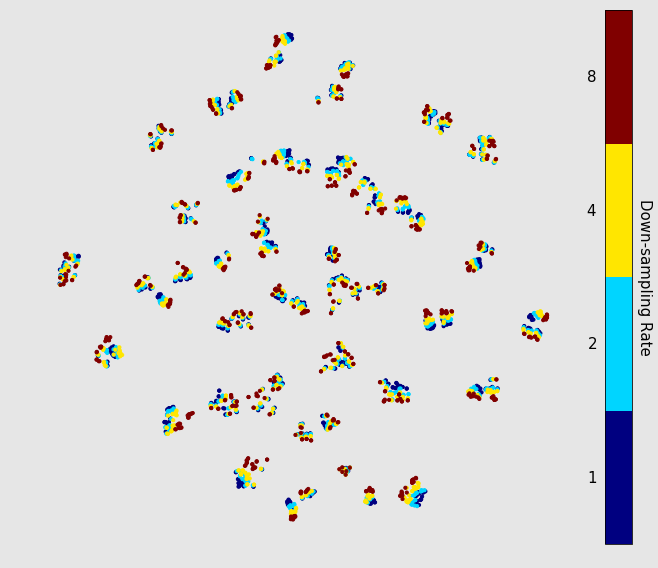

In [263]:
from pylab import rcParams

rcParams.update({'figure.autolayout': True})
rcParams['figure.figsize'] = 30, 40

bg_color = '#E6E6E6'
plt.figure(1)
fig, ax = plt.subplots(figsize=(10,8), facecolor=bg_color)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=np.stack(downsamples), cmap=plt.cm.get_cmap("jet", 4),s=10)
# plt.colorbar(ticks=range(4))
cbar = plt.colorbar()
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['$1$','$2$','$4$','$8$']):
    cbar.ax.text(-.5, (2 * j + 1) / 8.0, lab, ha='center', va='center', fontsize=15)
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('Down-sampling Rate', rotation=270, fontsize=15)

# plt.clim(-0.5, 9.5)
plt.axis('off')
plt.savefig('Reso_tsne_bar.pdf')

ValueError: c of shape (2736,) not acceptable as a color sequence for x with size 2, y with size 2

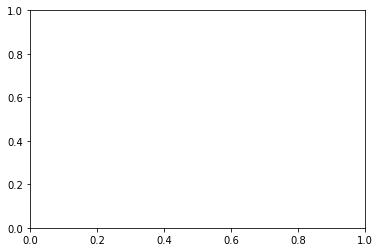

In [74]:
# import numpy as np
# # from skdata.mnist.views import OfficialImageClassification
# from matplotlib import pyplot as plt
# from sklearn.manifold import TSNE
# # load up data

# x_data = np.stack(features_list)
# y_data = np.stack(infos)
# # convert image data to float64 matrix. float64 is need for bh_sne
# # x_data = np.asarray(x_data).astype('float64')
# # x_data = x_data.reshape((x_data.shape[0], -1))
# # For speed of computation, only run on a subset

# # x_data = x_data[:n]
# # y_data = y_data[:n]
# # perform t-SNE embedding
# # vis_data = bh_sne(x_data)
# X_embedded = TSNE(n_components=2).fit_transform(x_data)

# # plot the result
# # vis_x = vis_data[:, 0]
# # vis_y = vis_data[:, 1]
# plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y_data, cmap=plt.cm.get_cmap("jet", 10))
# plt.colorbar(ticks=range(35))
# plt.clim(-0.5, 9.5)
# plt.show()

8

In [264]:
index_n = 234
print(matrix_argsort_1[index_n][:20])
print(matrix_argsort_2[index_n][:20])
print(matrix_argsort_4[index_n][:20])
print(matrix_argsort_8[index_n][:20])
print(match[index_n])

NameError: name 'matrix_argsort_1' is not defined

In [ ]:
Good_id[]

In [324]:
index_list = []
for index, data in enumerate(CMC):
    if data[0] == 1:
        index_list.append(index)

In [325]:
len(index_list)

248

In [ ]:
good_list = [400, ]

In [85]:
np.sum(matrix_argsort_1 == matrix_argsort_8)/len(matrix_argsort_2)/len(matrix_argsort_2)

1.0

In [79]:
len(matrix_argsort_2)

1930

In [80]:
np.sum(matrix_argsort_1 == matrix_argsort_2)

3724900

In [69]:
import pandas as pd

In [71]:
pd.read_csv('/home/yujheli/Project/ycchen/Adapt-ReID/data/csv/CUHK03/query_list.csv')[242:251]

,image_path,id,camera,downsample
242,images/00000172_01_0000.jpg,12,1,1
243,images/00000172_01_0001.jpg,12,1,1
244,images/00000172_01_0002.jpg,12,1,1
245,images/00000172_01_0003.jpg,12,1,1
246,images/00000172_01_0004.jpg,12,1,1
247,images/00000172_01_0005.jpg,12,1,1
248,images/00000172_01_0006.jpg,12,1,1
249,images/00000172_01_0007.jpg,12,1,1
250,images/00000172_01_0008.jpg,12,1,1


In [73]:
pd.read_csv('/home/yujheli/Project/ycchen/Adapt-ReID/data/csv/CUHK03/query_list.csv')[234:235]

,image_path,id,camera,downsample
234,images/00000172_00_0002.jpg,12,0,1
